In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import datetime
import time 
import keras
from keras.models import load_model
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dropout
#%matplotlib inline 
import matplotlib.pyplot as plt
import copy
from keras.utils.vis_utils import plot_model
    
def DrawText(img,sText,x,y):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    posf = (x,y)
    fontScale              = 5
    fontColor              = (255,255,255)
    thickness              = 1
    lineType               = 2
    print("Masuk")
    cv2.putText(img,sText, 
        posf, 
        font, 
        fontScale,
        fontColor,
        thickness,
        lineType)
    return copy.deepcopy(img)
    

def LoadCitraTraining(sDir,LabelKelas):
  
  JumlahKelas=len(LabelKelas)
  TargetKelas = np.eye(JumlahKelas)
  
  # Menyiapkan variabel list untuk data menampung citra dan data target
  X=[]#Menampung Data Citra
  T=[]#Menampung Target
  for i in range(len(LabelKelas)):    
    #Membaca file citra di setiap direktori data set  
    DirKelas = os.path.join(sDir, LabelKelas[i])
    files = os.listdir(DirKelas)
    
    for f in files:
      ff=f.lower()  
      print(f)
      #memilih citra dengan extensi jpg,jpeg,dan png
      if (ff.endswith('.jpg')|ff.endswith('.jpeg')|ff.endswith('.png')):
         NmFile = os.path.join(DirKelas,f)
         #membaca citra berwarna sebagai data bertipe double 
         img= np.double(cv2.imread(NmFile,1))
         img=cv2.resize(img,(256,256));
         #Normalisasi data citra menjadi sehingga maksimum menjadi 1
         img= np.asarray(img)/255;
         img=img.astype('float32')
         #Menambahkan citra dan target ke daftar
         X.append(img)
         T.append(TargetKelas[i])
     #--------akhir loop :Pfor f in files-----------------
  #-----akhir  loop :for i in range(len(LabelKelas))----
  
  #Mengubah List Menjadi numppy array
  X=np.array(X)
  T=np.array(T)
  X=X.astype('float32')
  T=T.astype('float32')
  return X,T

def LoadCitraTraining2(sDir, LabelKelas, augmentasi=True):
    JumlahKelas = len(LabelKelas)
    TargetKelas = np.eye(JumlahKelas)

    # Menyiapkan variabel list untuk data menampung citra dan data target
    X = []  # Menampung Data Citra
    T = []  # Menampung Target

    for i in range(len(LabelKelas)):
        # Membaca file citra di setiap direktori data set
        DirKelas = os.path.join(sDir, LabelKelas[i])
        files = os.listdir(DirKelas)

        for f in files:
            ff = f.lower()
            # Memilih citra dengan extensi jpg, jpeg, dan png
            if ff.endswith('.jpg') or ff.endswith('.jpeg') or ff.endswith('.png'):
                NmFile = os.path.join(DirKelas, f)
                # Membaca citra berwarna sebagai data bertipe double
                img = np.double(cv2.imread(NmFile, 1))
                img = cv2.resize(img, (256, 256))
                # Normalisasi data citra menjadi sehingga maksimum menjadi 1
                img = np.asarray(img) / 255
                img = img.astype('float32')
                # Menambahkan citra dan target ke daftar
                X.append(img)
                T.append(TargetKelas[i])

                if augmentasi:
                    # Augmentasi citra dengan flipping horizontal
                    img_flip = cv2.flip(img, 1)
                    X.append(img_flip)
                    T.append(TargetKelas[i])

                    # Augmentasi citra dengan flipping vertikal
                    img_flip = cv2.flip(img, 0)
                    X.append(img_flip)
                    T.append(TargetKelas[i])

                    # Augmentasi citra dengan pergeseran horizontal
                    rows, cols, ch = img.shape
                    M = np.float32([[1, 0, 50], [0, 1, 0]])
                    img_trans = cv2.warpAffine(img, M, (cols, rows))
                    X.append(img_trans)
                    T.append(TargetKelas[i])

                    # Augmentasi citra dengan pergeseran vertikal
                    rows, cols, ch = img.shape
                    M = np.float32([[1, 0, 0], [0, 1, 50]])
                    img_trans = cv2.warpAffine(img, M, (cols, rows))
                    X.append(img_trans)
                    T.append(TargetKelas[i])

                    # Augmentasi citra dengan rotasi 90 derajat
                    img_rot = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    X.append(img_rot)
                    T.append(TargetKelas[i])

                    # Rotasi 90 derajat counter-clockwise
                    img_rotated = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    X.append(img_rotated)
                    T.append(TargetKelas[i])

    # Mengubah List Menjadi numpy array
    X = np.array(X)
    T = np.array(T)
    X = X.astype('float32')
    T = T.astype('float32')
    return X, T


def ModelDeepLearningCNN(JumlahKelas):
    input_img = Input(shape=(256, 256, 3)) 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  
    x = MaxPooling2D((2, 2), padding='same')(x)   
    #x = Dropout(0.25)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)   
    x = MaxPooling2D((2, 2), padding='same')(x)   
    x = Dropout(0.25)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(100, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(JumlahKelas, activation='softmax')(x)
    ModelCNN = Model(input_img, x)  
    #ModelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #ModelCNN.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #plot_model(ModelCNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    # Augmentasi data
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    ModelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return ModelCNN


def TrainingCNN(JumlahEpoh,DirektoriDataSet,DirektoriDatasetTest,LabelKelas,NamaFileBobot ='weight.h5' ):
    #Membaca Data training dan label Kelas 
    X,D=LoadCitraTraining(DirektoriDataSet,LabelKelas)
    X_test , Y_test = LoadCitraTraining(DirektoriDatasetTest,LabelKelas)
    JumlahKelas = len(LabelKelas)
    #Membuat Model CNN
    ModelCNN =ModelDeepLearningCNN(JumlahKelas)
    #Trainng
    history=ModelCNN.fit(X, D,epochs=JumlahEpoh, validation_data=(X_test,Y_test))
    #Menyimpan hasil learning
    ModelCNN.save(NamaFileBobot)
    #Mengembalikan output 
    return ModelCNN,history



##########################################################
def Klasifikasi(Image,ModelCNN):

  X=[]
  ls = [];

  img= copy.deepcopy(Image)
  img=cv2.resize(img,(256,256))
  img= np.asarray(img)/255
  img=img.astype('float32')
  X.append(img)  
  X=np.array(X)
  X=X.astype('float32')
  hs=ModelCNN.predict(X,verbose=0)

  if hs.max()>0.5:
      idx = np.max(np.where( hs == hs.max()))
  else:
    idx=-1
      
 
  return idx
def GetFileName():
        x = datetime.datetime.now()
        s = x.strftime('%Y-%m-%d-%H%M%S%f')
        return s
def CreateDir(path):
    ls = [];
    head_tail = os.path.split(path)
    ls.append(path)
    while len(head_tail[1])>0:  
        head_tail = os.path.split(path)
        path = head_tail[0]
        ls.append(path)
        head_tail = os.path.split(path)   
    for i in range(len(ls)-2,-1,-1):
        sf =ls[i]
        isExist = os.path.exists(sf)
        if not isExist:
            os.makedirs(sf)
NamaDataSet = "TanganSamping"



def CreateDataSet(NoKamera,NamaDataSet):
    DirektoriData = "d:\\temp\\ambildata_jauh"+"\\"+NamaDataSet+"\\"+GetFileName()    
    CreateDir(DirektoriData)        
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    imsize=(640, 480)
    height = imsize[1]
    width = imsize[0]
    TimeStart = time.time() 
    TimeNow = time.time() +10
    FrameRate = 5
    
    # Define the upper body connections
    UPPER_BODY_CONNECTIONS = [
        (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER),
        (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW),
        (mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST),
        (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW),
        (mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST),
        (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP),
        (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP),
        (mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP),
        ]
    
    # For webcam input:
    cap = cv2.VideoCapture(NoKamera,cv2.CAP_DSHOW)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:
      
      while cap.isOpened():
        success, image = cap.read()
        if not success:
          print("Ignoring empty camera frame.")
          # If loading a video, use 'break' instead of 'continue'.
          continue
    
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        ori = copy.deepcopy(image)
       
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, imsize)
     
       
        results = pose.process(image)
        if not results.pose_landmarks:
         continue
        lm = []
        
    
        for lmark in results.pose_landmarks.landmark:
            print(lmark)
            if (lmark.x>0.01)and(lmark.x<1-0.01)and(lmark.y>0.01)and(lmark.y<1-0.01):
                m = [lmark.x*width  , lmark.y*height]
                lm.append(m)
        if len(lm) ==0:
            continue
        lm = np.array(lm)
        x = lm[:,0]
        y = lm[:,1]
        ymin = np.min(y)
        ymax = np.max(y)
        xmin =np.min(x)
        xmax =np.max(x)
            
                
            
        ymin = np.int32(np.min(y))-3
        ymax = np.int32(np.max(y))-3
        xmin = np.int32(np.min(x))+3
        xmax = np.int32(np.max(x))+3
    
        
        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        bimage = np.zeros((height,width,3), np.uint8)
        #cv2.rectangle(bimage,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            UPPER_BODY_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
             )
        
        
        mp_drawing.draw_landmarks(
            bimage,
            results.pose_landmarks,
            UPPER_BODY_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
             )
 
        #image = cv2.rectangle(image, (xmin,ymin),(xmax,ymax), (255,0,0),2)
                          
        cropped_image = bimage[ymin:ymax, xmin:xmax,:]
        dy =ymax -ymin
        dx = xmax -xmin
        print(dy,dx)
        print(cropped_image.shape)
        TimeNow = time.time() 
        if TimeNow-TimeStart>1/FrameRate:
            print(cropped_image.shape)
            TimeStart = TimeNow
            sFile = DirektoriData+"\\"+GetFileName()
            imsize2=(128,128)
            cropped_image = cv2.resize(cropped_image, imsize2)
            cv2.imwrite(sFile+'.jpg', bimage)
            #cv2.imwrite(sFile+'.png', image)
            #cv2.imwrite(sFile+'.bmp', ori)
            
            
        #cv2.flip(image, 1)
        cv2.imshow('MediaPipe Pose', image)
        if cv2.waitKey(5) & 0xFF == 27:
          break
    cap.release()
    cv2.destroyAllWindows()
    
def TesPosePrediction(DirDataSet,DirKlasifikasi,LabelKelas,ModelCNN=[]):
#Apabila parameter input ModelCNN tidak di isi maka
#   akan menggunakan bobot pada file 'weight.h5
  if not(ModelCNN):
      ModelCNN = load_model('weight.h5') 
      
#Menyiapkan Data input Yang akan di kasifikasikan
  X=[]
  ls = [];
  DirKelas = DirDataSet+"\\"+DirKlasifikasi
  print(DirKelas)
  files = os.listdir(DirKelas)
  n=0;
  for f in files:
      ff=f.lower()  
      print(f)
      if (ff.endswith('.jpg')|ff.endswith('.jpeg')|ff.endswith('.png')):
         ls.append(ff) 
         NmFile = os.path.join(DirKelas,f)
         img= cv2.imread(NmFile,1)
         img=cv2.resize(img,(128,128))
         img= np.asarray(img)/255
         img=img.astype('float32')
         X.append(img)
     #----Akhir if-------------
  #---Akhir For 
  X=np.array(X)
  X=X.astype('float32')
  #Melakukan prediksi Klasifikasi
  hs=ModelCNN.predict(X)
  
  LKlasifikasi=[];
  LKelasCitra =[];
  n = X.shape[0]
  for i in range(n):
      v=hs[i,:]
      if v.max()>0.5:
          idx = np.max(np.where( v == v.max()))
          LKelasCitra.append(LabelKelas[idx])
      else:
          idx=-1
          LKelasCitra.append("-")
      #------akhir if
      LKlasifikasi.append(idx);
  #----akhir for
  LKlasifikasi = np.array(LKlasifikasi)
  return ls, hs, LKelasCitra

def PredictPose(NoKamera,LabelKelas):
    ModelCNN = load_model('weight.h5') 
    

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    imsize=(352, 256)
    height = imsize[1]
    width = imsize[0]

    # Define the upper body connections
    UPPER_BODY_CONNECTIONS = [
    (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.RIGHT_SHOULDER),
    (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_ELBOW),
    (mp_pose.PoseLandmark.LEFT_ELBOW, mp_pose.PoseLandmark.LEFT_WRIST),
    (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_ELBOW),
    (mp_pose.PoseLandmark.RIGHT_ELBOW, mp_pose.PoseLandmark.RIGHT_WRIST),
    (mp_pose.PoseLandmark.LEFT_SHOULDER, mp_pose.PoseLandmark.LEFT_HIP),
    (mp_pose.PoseLandmark.RIGHT_SHOULDER, mp_pose.PoseLandmark.RIGHT_HIP),
    (mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.RIGHT_HIP),
    #(mp_pose.PoseLandmark.LEFT_HIP, mp_pose.PoseLandmark.LEFT_KNEE),
    #(mp_pose.PoseLandmark.LEFT_KNEE, mp_pose.PoseLandmark.LEFT_ANKLE),
    #(mp_pose.PoseLandmark.RIGHT_HIP, mp_pose.PoseLandmark.RIGHT_KNEE),
    #(mp_pose.PoseLandmark.RIGHT_KNEE, mp_pose.PoseLandmark.RIGHT_ANKLE)
    ]

    # For webcam input:
    cap = cv2.VideoCapture(NoKamera,cv2.CAP_DSHOW)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:
      
      while cap.isOpened():
        success, image = cap.read()
        if not success:
          print("Ignoring empty camera frame.")
          # If loading a video, use 'break' instead of 'continue'.
          continue
          
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, imsize)
     
        results = pose.process(image)
        if not results.pose_landmarks:
         continue
        lm = []
        
    
        for lmark in results.pose_landmarks.landmark:
            
            if (lmark.x>0.01)and(lmark.x<1-0.01)and(lmark.y>0.01)and(lmark.y<1-0.01):
                m = [lmark.x*width  , lmark.y*height]
                lm.append(m)
        if len(lm) ==0:
            continue
        lm = np.array(lm)
        x = lm[:,0]
        y = lm[:,1]
        ymin = np.min(y)
        ymax = np.max(y)
        xmin =np.min(x)
        xmax =np.max(x)
            
                
            
        ymin = np.int32(np.min(y))-3
        ymax = np.int32(np.max(y))-3
        xmin = np.int32(np.min(x))+3
        xmax = np.int32(np.max(x))+3
    
        
        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        bimage = np.zeros((height,width,3), np.uint8)
        #cv2.rectangle(bimage,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            UPPER_BODY_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
            )
        
        
        mp_drawing.draw_landmarks(
            bimage,
            results.pose_landmarks,
            UPPER_BODY_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
            )
        cropped_image = bimage[ymin:ymax, xmin:xmax,:]
        idx = Klasifikasi(cropped_image, ModelCNN)
        x=60
        y=60
        #image= cv2.flip(image, 1)
    
        if idx>=0:
            cv2.putText(image,LabelKelas[idx], (x,y), cv2.FONT_HERSHEY_SIMPLEX,2.0, (255, 255, 0), 3)
        
        
        #masukan = []
        #for _ in range(idx):
           #masukan.append(LabelKelas[idx])
        
        #mapping = ','.join(masukan)

        #print(mapping)

        cv2.imshow('MediaPipe Pose', image)
        
       
        if cv2.waitKey(5) & 0xFF == 27:
          break
    cap.release()
    cv2.destroyAllWindows()

In [4]:
LabelKelas=["A","B","C","D","E"]

PredictPose(0,LabelKelas)
    

In [ ]:
CreateDataSet(0,"G")

In [5]:
#Training Data Set
DirektoriDataSet="D:\\temp\\trainingdataset4"
DirektoriDatasetTest = "D:\\temp\\validasidataset4"
#   Data Set disimpan dalam direktori yang sama dengan nama kelas    

#b. Label Data Set 
LabelKelas=("A","B","C","D","E")

#c. Inisialisasi parameter Training
JumlahEpoh = 20;

#d. training
ModelCNN,history = TrainingCNN(JumlahEpoh,DirektoriDataSet,DirektoriDatasetTest,LabelKelas)
ModelCNN.summary()



2023-04-02-174843400154.jpg
2023-04-02-174843653497.jpg
2023-04-02-174843859818.jpg
2023-04-02-174844115975.jpg
2023-04-02-174844324345.jpg
2023-04-02-174844578891.jpg
2023-04-02-174844787351.jpg
2023-04-02-174845061948.jpg
2023-04-02-174845319850.jpg
2023-04-02-174845523432.jpg
2023-04-02-174845779466.jpg
2023-04-02-174845992026.jpg
2023-04-02-174846246091.jpg
2023-04-02-174846452126.jpg
2023-04-02-174846724142.jpg
2023-04-02-174846979363.jpg
2023-04-02-174847194022.jpg
2023-04-02-174847446139.jpg
2023-04-02-174847655629.jpg
2023-04-02-174847907542.jpg
2023-04-02-174848115288.jpg
2023-04-02-174848390123.jpg
2023-04-02-174848646989.jpg
2023-04-02-174848851915.jpg
2023-04-02-174849107184.jpg
2023-04-02-174849316026.jpg
2023-04-02-174849571422.jpg
2023-04-02-174849780504.jpg
2023-04-02-174850052210.jpg
2023-04-02-174850308582.jpg
2023-04-02-174850516251.jpg
2023-04-02-174850771869.jpg
2023-04-02-174850979169.jpg
2023-04-02-174851236372.jpg
2023-04-02-174851444142.jpg
2023-04-02-174851703

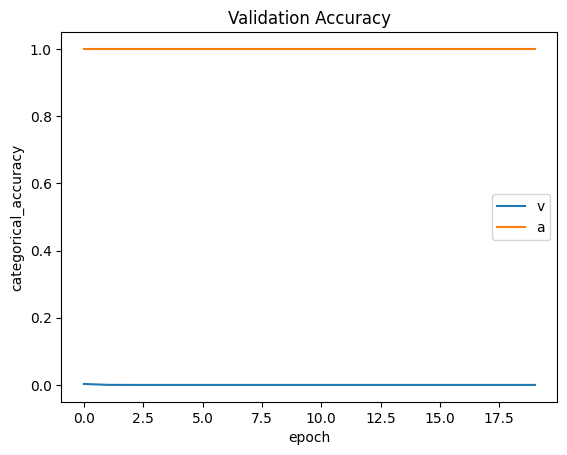

In [9]:
#c. Menampilkan Grafik Loss dan accuracy
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.legend('val loss')

plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.xlabel('epoch')
plt.ylabel('categorical_accuracy')
plt.legend("val accuracy")
plt.show()